In [1]:
import os
import random
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing and loading

In [2]:
# Define functions for augmentation and MFCC extraction
def add_background_noise(y):
    noise = np.random.randn(len(y))
    y_noisy = y + 0.005 * noise
    return y_noisy

def augment_data(y, sr):
    y_noisy = add_background_noise(y)
    return y_noisy

def extract_mfcc(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfcc

def resize_mfcc(mfcc, max_len=100):
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

def normalize_mfcc(mfcc):
    return (mfcc - np.mean(mfcc)) / np.std(mfcc)

##### Loading data

In [3]:
# Load the data
data_folder = 'D:/UNI/Year 4 Term 1/speech/assignment/assignment data' #replace with your data path
X, y = [], []

# Loop through each label folder with a progress bar
for label in tqdm(os.listdir(data_folder), desc="Processing Labels"):
    label_folder = os.path.join(data_folder, label)
    
    # Loop through each audio file with a progress bar
    for audio_file in tqdm(os.listdir(label_folder), desc=f"Processing {label}", leave=False):
        file_path = os.path.join(label_folder, audio_file)
        y_audio, sr = librosa.load(file_path, sr=22050)
        X.append(y_audio)
        y.append(label)

Processing Labels: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


In [4]:
#lenght of the data (records)
len(X), len(y)

(23666, 23666)

In [5]:
# Encode labels
label_to_index = {label: idx for idx, label in enumerate(set(y))}
y = [label_to_index[label] for label in y]

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Data augmentation

In [7]:
# Augment the training data and extract MFCC features
X_train_augmented, y_train_augmented = [], []

for i, original_audio in tqdm(enumerate(X_train), total=len(X_train)):
    # Add noise
    augmented_noisy = augment_data(original_audio, sr=22050)
    # Process augmented data
    mfcc_augmented = extract_mfcc(augmented_noisy, sr=22050)
    mfcc_resized = resize_mfcc(mfcc_augmented)
    mfcc_normalized = normalize_mfcc(mfcc_resized)
    
    X_train_augmented.append(mfcc_normalized)
    y_train_augmented.append(y_train[i])  # Keep original label
        # Combine original and augmented data for training
X_train_mfcc = [normalize_mfcc(resize_mfcc(extract_mfcc(audio, sr=22050))) for audio in X_train]
X_train_mfcc += X_train_augmented
y_train += y_train_augmented

100%|██████████| 18932/18932 [01:19<00:00, 239.62it/s]


In [8]:
X_test_mfcc = [normalize_mfcc(resize_mfcc(extract_mfcc(audio, sr=22050))) for audio in tqdm(X_test, desc="Extracting MFCCs for Test Data")]

Extracting MFCCs for Test Data: 100%|██████████| 4734/4734 [00:15<00:00, 300.59it/s]


In [9]:
# training data after augmentation
print(np.array(X_train_mfcc).shape)
len(X_train_mfcc), len(y_train), len(X_test_mfcc), len(y_test)

(37864, 13, 100)


(37864, 37864, 4734, 4734)

# Model Implementation

In [10]:
# Convert data to numpy arrays
X_train_mfcc = np.array(X_train_mfcc)
y_train = np.array(y_train)
X_test_mfcc = np.array(X_test_mfcc)
y_test = np.array(y_test)

In [11]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(13, 100, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_to_index), activation='softmax')
])

d:\prog apps\python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
#Reshape data to ensure compatibilty for the model
X_train_mfcc = X_train_mfcc[..., np.newaxis]
X_test_mfcc = X_test_mfcc[..., np.newaxis]

Epoch 1/10
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4716 - loss: 1.4817 - val_accuracy: 0.8555 - val_loss: 0.4510
Epoch 2/10
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8180 - loss: 0.5643 - val_accuracy: 0.9011 - val_loss: 0.3125
Epoch 3/10
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8630 - loss: 0.4225 - val_accuracy: 0.9151 - val_loss: 0.2809
Epoch 4/10
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8832 - loss: 0.3593 - val_accuracy: 0.9180 - val_loss: 0.2570
Epoch 5/10
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9028 - loss: 0.3030 - val_accuracy: 0.9136 - val_loss: 0.2747
Epoch 6/10
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9074 - loss: 0.2839 - val_accuracy: 0.9237 - val_loss: 0.2424
Epoch 7/10
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9198 - loss: 0.2504 - val_accuracy: 0.9218 - val_loss: 0.2365
Epoch 8/10
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9235 - loss: 0.2280 - 

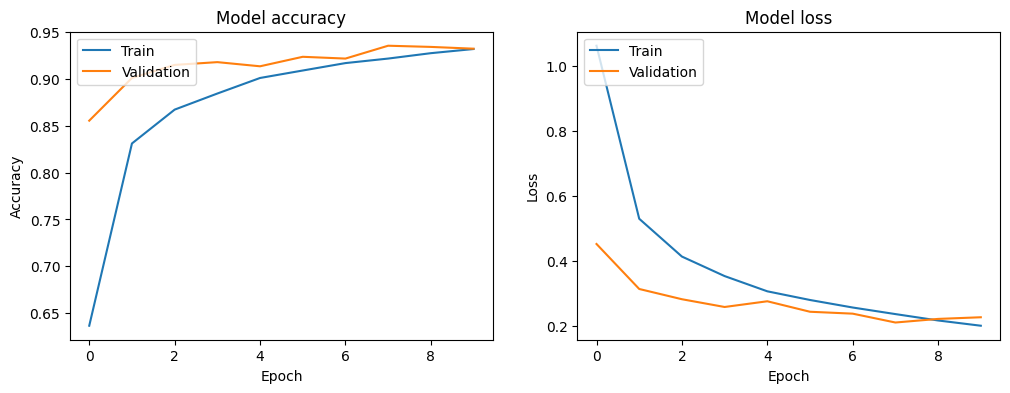

In [14]:
# Train the model
history = model.fit(X_train_mfcc, y_train, epochs=10, batch_size=32, validation_data=(X_test_mfcc, y_test))
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [15]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_mfcc, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

148/148 - 0s - 2ms/step - accuracy: 0.9324 - loss: 0.2254
Test accuracy: 0.9324038624763489


## Model preformance and confusion matrix

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

       eight       0.96      0.91      0.94       443
         one       0.95      0.93      0.94       451
       seven       0.95      0.90      0.92       474
        five       0.91      0.94      0.93       520
        nine       0.92      0.93      0.93       450
       three       0.92      0.94      0.93       471
        four       0.87      0.96      0.92       448
         six       0.91      0.97      0.94       500
        zero       0.98      0.92      0.95       490
         two       0.95      0.92      0.93       487

    accuracy                           0.93      4734
   macro avg       0.93      0.93      0.93      4734
weighted avg       0.93      0.93      0.93      4734



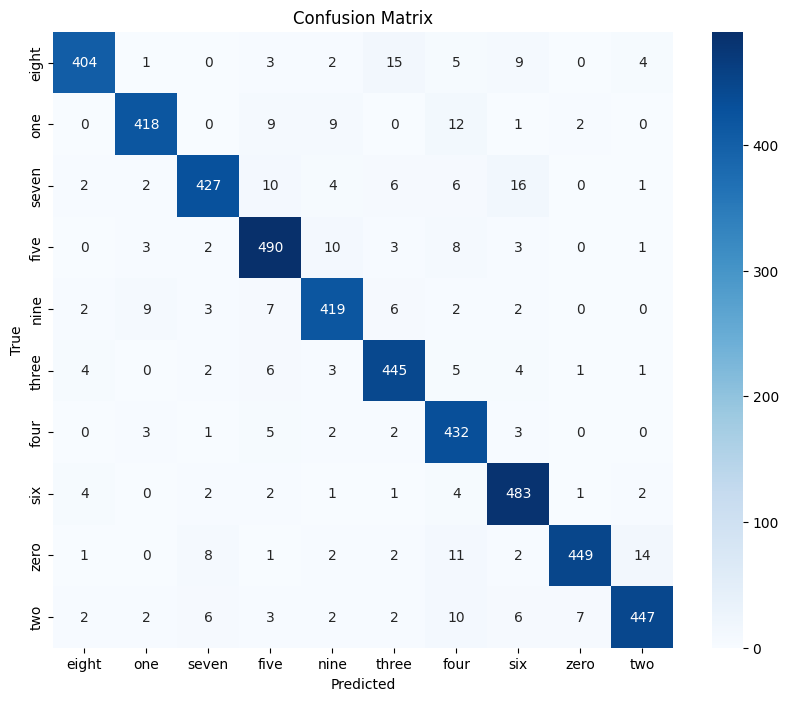

In [16]:
# Make predictions
y_pred = model.predict(X_test_mfcc)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=label_to_index.keys()))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()